In [1]:
# imports
from importlib import reload

import os # a module to interact with the operating system
os.environ["ENDPOINT_URL"]="http://rook-ceph-rgw-nautiluss3.rook"
import numpy as np

import pandas as pd
import xarray
import h5py
import healpy as hp
import time

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.plotting import plotting as ulmo_plotting
from ulmo.analysis import spatial_plots as sp

# Load Table

In [2]:
llc_uniform= ulmo_io.load_main_table( 's3://llc/Tables/test_uniform_r0.5_test.feather' )
llc_uniform.head()

Read main table: s3://llc/Tables/test_uniform_r0.5_test.feather


,lat,lon,row,col,datetime,LLC_file,pp_file,pp_root,field_size,mean_temperature,...,T10,pp_idx,pp_type,LL,U_mean,V_mean,U_rms,V_rms,UV_mean,UV_rms
0,71.725098,-177.172684,12895,10607,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,-1.467546,...,-1.541000,647491,0,648.981934,-0.099179,-0.001986,0.059771,0.063255,0.141285,0.082805
1,71.747978,-175.380554,12895,10676,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,-0.492408,...,-1.540001,384768,0,-513.771851,-0.008606,-0.042140,0.041484,0.108360,0.046431,0.037870
2,71.758400,-173.559555,12895,10746,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,3.271719,...,2.540999,283882,0,345.448669,0.070156,-0.045817,0.022577,0.044823,0.099820,0.029986
3,71.755905,-171.737854,12895,10816,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,2.945127,...,2.229000,613023,0,169.709839,0.081717,-0.010355,0.024675,0.039160,0.115622,0.034708
4,71.740822,-169.943695,12895,10885,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,2.364319,...,1.891000,537161,0,349.981262,0.039346,0.019852,0.023803,0.031211,0.057416,0.030541


In [3]:
llc_tbl= ulmo_io.load_main_table( 's3://llc/Tables/LLC_uniform_viirs_noise.parquet' )
llc_tbl.head()

Read main table: s3://llc/Tables/LLC_uniform_viirs_noise.parquet


,lat,lon,row,col,datetime,LLC_file,pp_file,pp_root,field_size,mean_temperature,...,T10,pp_idx,pp_type,U_mean,V_mean,U_rms,V_rms,UV_mean,UV_rms,LL
0,71.725098,-177.172684,12895,10607,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,-1.467546,...,-1.541000,647491,0,-0.099179,-0.001986,0.059771,0.063255,0.141285,0.082805,642.516968
1,71.747978,-175.380554,12895,10676,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,-0.492408,...,-1.540001,384768,0,-0.008606,-0.042140,0.041484,0.108360,0.046431,0.037870,-508.767731
2,71.758400,-173.559555,12895,10746,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,3.271719,...,2.540999,283882,0,0.070156,-0.045817,0.022577,0.044823,0.099820,0.029986,345.613159
3,71.755905,-171.737854,12895,10816,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,2.945127,...,2.229000,613023,0,0.081717,-0.010355,0.024675,0.039160,0.115622,0.034708,169.615540
4,71.740822,-169.943695,12895,10885,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,2.364319,...,1.891000,537161,0,0.039346,0.019852,0.023803,0.031211,0.057416,0.030541,343.068726


# High LL group

In [5]:
highn = llc_uniform[(llc_uniform.LL > 600)]
highn.index

Int64Index([     0,     19,     21,     22,     31,     59,     60,     61,
                62,     63,
            ...
            781652, 781653, 781654, 781655, 781656, 781657, 781658, 781659,
            781660, 781661],
           dtype='int64', length=361207)

In [6]:
highy = llc_tbl.iloc[highn.index]

In [9]:
diff = highy.LL - highn.LL

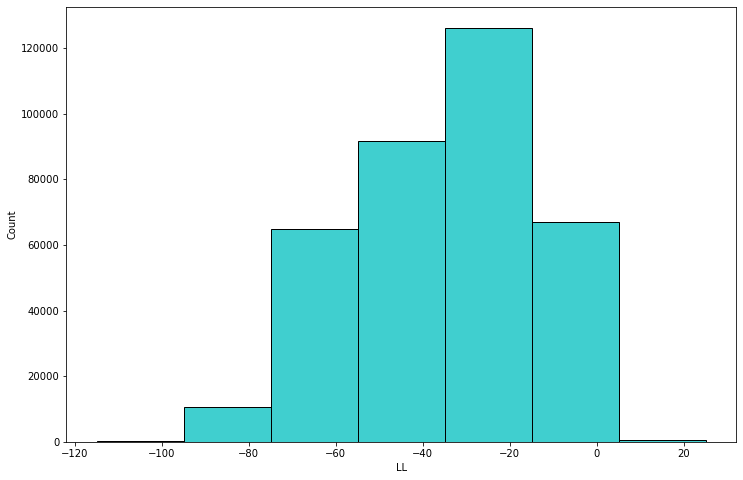

In [11]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()
_ = sns.histplot(diff, ax=ax, stat = 'count', binwidth=20, color = 'c')

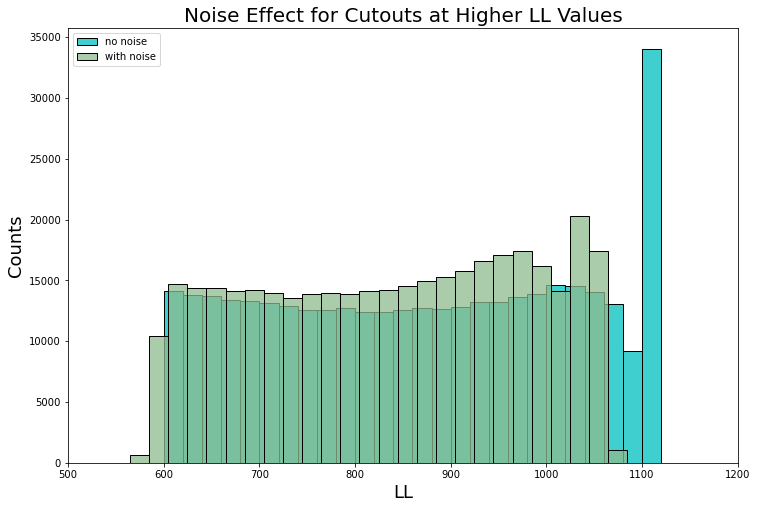

In [37]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()
_ = sns.histplot(highn, x='LL', ax=ax, stat = 'count', label ='no noise', binwidth=20, color = 'c')
_ = sns.histplot(highy, x='LL', ax=ax, stat = 'count', label ='with noise', binwidth=20, color = 'darkseagreen')

ax.set_xlim(500., 1200.)
ax.set_xlabel( 'LL', fontsize = 18)
ax.set_ylabel( 'Counts', fontsize = 18)
ax.set_title( 'Noise Effect for Cutouts at Higher LL Values', fontsize = 20)
ax.legend()

plt.savefig( 'Noise_effect_LLC_uniform_high_LL', dpi = 300)

# Low LL Group

In [12]:
lown = llc_uniform[ (llc_uniform.LL > 0) & (llc_uniform.LL < 600)]
lown.index

Int64Index([     2,      3,      4,      5,      6,      7,      8,      9,
                10,     11,
            ...
            778747, 778748, 778752, 778755, 778757, 778758, 778965, 778969,
            779163, 779164],
           dtype='int64', length=366321)

In [13]:
lowy = llc_tbl.iloc[lown.index]

In [15]:
diffl = lowy.LL - lown.LL

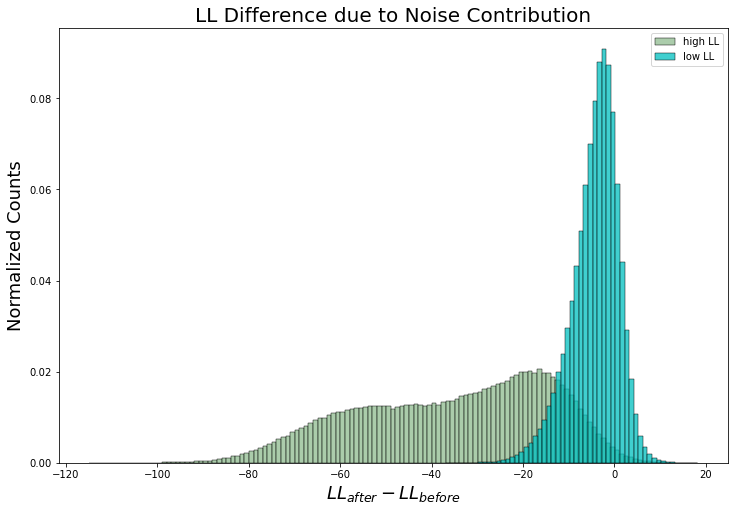

In [30]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()
_ = sns.histplot(diff, ax=ax, stat = 'density', binwidth=1, label = 'high LL', color = 'darkseagreen')
_ = sns.histplot(diffl, ax=ax, stat = 'density', binwidth=1, label = 'low LL', color = 'c')

ax.legend()
ax.set_title('LL Difference due to Noise Contribution', fontsize = 20)
ax.set_ylabel('Normalized Counts', fontsize = 18)
ax.set_xlabel(r'$LL_{after} - LL_{before}$', fontsize = 18)

#plt.savefig( 'LL_diff_noise_LLC', dpi = 300)

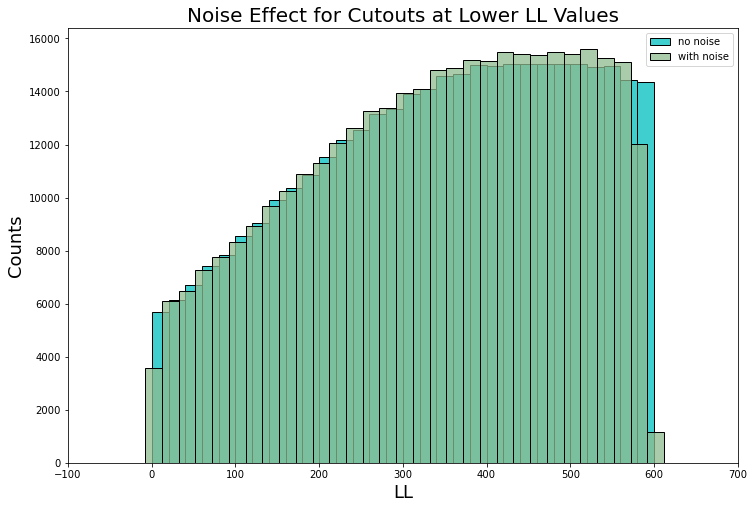

In [36]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()
_ = sns.histplot(lown, x='LL', ax=ax, stat = 'count', label ='no noise', binwidth=20, color = 'c')
_ = sns.histplot(lowy, x='LL', ax=ax, stat = 'count', label ='with noise', binwidth=20, color = 'darkseagreen')

ax.set_xlim(-100, 700)
ax.set_xlabel( 'LL', fontsize = 18)
ax.set_ylabel( 'Counts', fontsize = 18)
ax.set_title( 'Noise Effect for Cutouts at Lower LL Values', fontsize = 20)
ax.legend()

#plt.savefig( 'Noise_effect_LLC_uniform_low_LL', dpi = 300)

In [ ]:

fig, axes = plt.subplots(5, 4, figsize = (20,25) )

_, cm = ulmo_plotting.load_palette()

with h5py.File('/home/jovyan/ulmo/ulmo/notebooks/LLC_modis2012_test_preproc.h5', 'r') as pp_hf:
    
    mean_T = pp_hf['valid_metadata'][:,7]
    
    for i, elem in enumerate(li):

        ax = axes[i][0]
        img = pp_hf['valid'][elem, 0, ...]
        g = sns.heatmap(np.flipud(img), xticklabels = [], yticklabels = [], cmap=cm, ax = ax)
        tmp = float( mean_T[elem].decode() )
        g.set_title('Mean T: {} C and noise_sigma: {}'.format(round(tmp), round(0.031 + 0.0048*tmp, 2)))
        
        ax = axes[i][1]
        
        h = sns.histplot(img.flatten(), stat = 'count', ax =ax, legend = False)
        h.set_title('SSTa hist w/o noise')
        
with h5py.File('/home/jovyan/ulmo/ulmo/notebooks/LLC_modis2012_test_SST_noise_preproc.h5', 'r') as pp_hf:
    
    for i, elem in enumerate(li):

        ax = axes[i][2]
        img = pp_hf['valid'][elem, 0, ...]
        g = sns.heatmap(np.flipud(img), xticklabels = [], yticklabels = [], cmap=cm, ax = ax)
        
        ax = axes[i][3]
        
        h = sns.histplot(img.flatten(), stat = 'count', ax = ax, legend = False)
        h.set_title('SSTa hist w/ noise')
    

plt.show()

In [13]:
cutouty = llc_tbl.iloc[1035]
cutoutn = llc_uniform.iloc[1035]

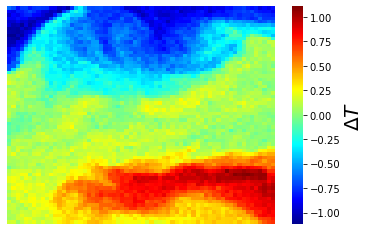

In [24]:
imgy = image_utils.grab_image(cutouty) # , local_file=local_preproc)
_, cm = ulmo_plotting.load_palette()
    
ax = sns.heatmap(np.flipud(imgy), xticklabels=[],
                     yticklabels=[], cmap=cm, cbar=True, cbar_kws={'label': r'$\Delta T$'})
ax.figure.axes[-1].yaxis.label.set_size(18)

plt.savefig('image', dpi=600)


In [25]:
pwd

'/home/jovyan/ulmo/ulmo/notebooks'

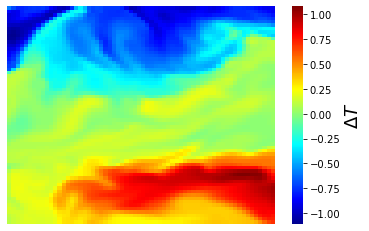

In [26]:
imgn = image_utils.grab_image(cutoutn) # , local_file=local_preproc)
_, cm = ulmo_plotting.load_palette()
    
ax = sns.heatmap(np.flipud(imgn), xticklabels=[],
                     yticklabels=[], cmap=cm, cbar=True, cbar_kws={'label': r'$\Delta T$'})
ax.figure.axes[-1].yaxis.label.set_size(18)

plt.savefig('image', dpi=600)